![Astrofisica Computacional](../logo.png)

# Computational Astrophysics 2021
---


## 04. Linear Regression using `SciKit Learn`

Eduard Larrañaga (ealarranaga@unal.edu.co)



### About this notebook

In this exercise, you will analize some data from the Bolshoi simulation to find linear correlations between some variables. 

---

## Linear Regression with dark matter halos

In this tutorial, we will practice how to carry out a simple linear regression task. The first step is to download a public dark matter halo catalogue from the Bolshoi simulation. It can be found at

http://www.slac.stanford.edu/~behroozi/Bolshoi_Catalogs/  

The catalogue at z=0 is named 'hlist_1.00035.list.gz'. Once it is unziped, the size of the datafile is about 8Gb and contains millions of samples. In order to illustrate the analysis of the data, a reduced version of this file, with approximately 21000 samples, is given with this notebook. This file is called 'bolshoi01.list' 

Complete information about the Bolshoi simulation can be found in the paper

A. Klypin, S. Trujillo-Gomez, J. Primack. *Halos and galaxies in the standard cosmological model: results from the Bolshoi simulation.*
https://arxiv.org/abs/1002.3660

Here, we will use `Pandas` to analyse this halo catalogue and to identify correlation between different halo properties. Then, we will use `Scikit-Learn` to predict the halo **concentration** from the other halo properties using a linear regression algorithm. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline

### Loading the data

In order to load the data from the file, we will use the function [numpy.genfromtxt()](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html) which is similar to the function `numpy.loadtxt()`, that we have used before, but gives some options that help when dealing with missing values. 

We will load the first 20000 samples.

In [2]:
#Load data from ascii file
data = np.genfromtxt("BolshoiData/bolshoi01.list",comments='#',max_rows=20000)

From the header of the datafile, you can identify the features included. Some of them are

| Column | Feature |
|---|:--|
|00| Scale: Scale factor of halo|
|01| ID: ID of halo (unique across entire simulation)|
|02| Desc_Scale: Scale of descendant halo, if applicable|
|03| Descid: ID of descendant halo, if applicable|
|04| Num_prog: Number of progenitors|
|05| Pid: ID of least massive host halo (-1 if distinct halo)|
|06| Upid: ID of most massive host halo (different from Pid when the halo is within two or more larger halos)|
|07| Desc_pid: Pid of descendant halo (if applicable)|
|08| Phantom: Nonzero for halos interpolated across timesteps|
|09| SAM_Mvir: Halo mass, smoothed across accretion history; always greater than sum of halo masses of contributing progenitors (Msun/h).  Only for use with select semi-analytic models|
|10| Mvir: Halo mass (Msun/h)|
|11| Rvir: Halo radius (kpc/h comoving)|
|12| Rs: Scale radius (kpc/h comoving)|
|13| Vrms: Velocity dispersion (km/s physical)|
|14| mmp?: whether the halo is the most massive progenitor or not|
|15| scale_of_last_MM: scale factor of the last major merger (Mass ratio > 0.3)|
|16| Vmax: Maxmimum circular velocity (km/s physical)|
|17:19| X / Y / Z: Halo position (Mpc/h comoving)|
|20:22| VX / VY / VZ: Halo velocity (km/s physical)|
|23:25| JX / JY / JZ: Halo angular momenta ((Msun/h) * (Mpc/h) * km/s (physical))|
|26| Spin: Halo spin parameter|
|27| Breadth_first_ID: breadth-first ordering of halos within a tree|
|28| Depth_first_ID: depth-first ordering of halos within a tree|
|29| Tree_root_ID: ID of the halo at the last timestep in the tree|
|30| Orig_halo_ID: Original halo ID from halo finder|
|31| Snap_num: Snapshot number from which halo originated|
|32| Next_coprogenitor_depthfirst_ID: Depthfirst ID of next coprogenitor|
|33| Last_progenitor_depthfirst_ID: Depthfirst ID of last progenitor|
|34| Last_mainleaf_depthfirst_ID: Depthfirst ID of last progenitor on main progenitor branch|
|35| Rs_Klypin: Scale radius determined using Vmax and Mvir (see Rockstar paper)|
|36| Mvir_all: Mass enclosed within the specified overdensity, including unbound particles (Msun/h)|
|37:40| M200b--M2500c: Mass enclosed within specified overdensities (Msun/h)|
|41| Xoff: Offset of density peak from average particle position (kpc/h comoving)|
|42| Voff: Offset of density peak from average particle velocity (km/s physical)|
|43| Spin_Bullock: Bullock spin parameter (J/(sqrt(2)*GMVR))|
|44:45| b_to_a, c_to_a: Ratio of second and third largest shape ellipsoid axes (B and C) to largest shape ellipsoid axis (A) (dimensionless).<br> Shapes are determined by the method in Allgood et al. (2006)|
|46:48| A[x],A[y],A[z]: Largest shape ellipsoid axis (kpc/h comoving)|
|49:50| b_to_a, c_to_a: Ratio of second and third largest shape ellipsoid axes (B and C) to largest shape ellipsoid axis (A) (dimensionless).<br> Shapes are determined by the method in Allgood et al. (2006). <br>(500c) indicates that only particles within R500c are considered|
|51:53| A[x],A[y],A[z]: Largest shape ellipsoid axis (kpc/h comoving).<br>(500c) indicates that only particles within R500c are considered|
|54| T/\|U\|: ratio of kinetic to potential energies|
|55:56| M_pe_*: Pseudo-evolution corrected masses (very experimental).Consistent Trees Version 1.0+. Includes fix for Rockstar spins & T/|U| (assuming T/|U| = column 53)|
|57|Macc: Mass at accretion|
|58|Mpeak: Peak mass over mass accretion history1|
|59|Vacc: Vmax at accretion|
|60|Vpeak: Peak Vmax over mass accretion history1|
|61|Halfmass_Scale: Scale factor at which the MMP reaches 0.5*Mpeak|
|62:64|Acc_Rate_\*: Halo mass accretion rates in Msun / h / yr <br>Inst: instantaneous; 100Myr: averaged over past 100Myr <br>X\*Tdyn: averaged over past X*virial dynamical time <br>Mpeak: Growth Rate of Mpeak, averaged from current z to z+0.5|

Now, we will extract some of these features.

In [3]:
#Extract halo properties

virial_mass   = np.log10(data[:,10])
virial_radius = np.log10(data[:,11])
concentration = np.log10(data[:,11] / data[:,12]) #Concentration is defined as virial radius divided by scale length
velocity_disp = np.log10(data[:,13])
vmax          = np.log10(data[:,16])
spin          = np.log10(data[:,26])
b_to_a        = data[:,44]
c_to_a        = data[:,45]
energy_ratio  = data[:,54]
peak_mass     = np.log10(data[:,58])
peak_vmax     = np.log10(data[:,60])
halfmass_a    = data[:,61]
peakmass_a    = data[:,67]
acc_rate      = data[:,64]

Since we will use `Pandas` to analyse the data and to identify correlation between these features, we will define a dataframe,

In [4]:

halos = pd.DataFrame({
    'Virial Mass':virial_mass,
    'Virial Radius':virial_radius,
    'Concentration':concentration,
    'Vel. Dispersion':velocity_disp,
    'Max. Velocity':vmax,
    'Halo Spin':spin,
    'B to A ratio':b_to_a,
    'C to A ratio':c_to_a,
    'Energy Ratio':energy_ratio,
    'Peak Virial Mass':peak_mass,
    'Peak Velocity':peak_vmax,
    'Half Mass Scale':halfmass_a,
    'Peak Mass Scale':peakmass_a,
    'Acc. Rate':acc_rate
})


halos

,Virial Mass,Virial Radius,Concentration,Vel. Dispersion,Max. Velocity,Halo Spin,B to A ratio,C to A ratio,Energy Ratio,Peak Virial Mass,Peak Velocity,Half Mass Scale,Peak Mass Scale,Acc. Rate
0,14.215638,3.054453,1.001863,2.984820,2.978815,-1.611899,0.72158,0.58089,0.6102,14.215638,3.023545,0.4023,1.0000,10670.00000
1,14.201124,3.049566,0.699512,2.947919,2.915458,-1.189297,0.56817,0.45925,0.6324,14.201124,2.964783,0.5043,1.0000,12860.00000
2,14.058426,3.001994,0.889922,2.907191,2.902775,-1.469160,0.85185,0.77602,0.5770,14.058426,2.944419,0.4803,1.0000,5633.00000
3,13.987175,2.978264,0.479754,2.879302,2.832106,-1.099578,0.57167,0.45266,0.7308,13.987175,2.832260,0.6403,1.0000,14900.00000
4,13.930796,2.959464,0.898464,2.872739,2.866689,-1.587707,0.70484,0.58662,0.5982,13.930796,2.907750,0.4864,1.0000,3519.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,10.283753,1.743768,1.431168,1.718585,1.755417,-1.635074,0.79234,0.73217,0.5904,10.488551,1.840921,0.3903,0.6283,-3.39500
19996,10.283753,1.743768,1.435631,1.678427,1.764923,-1.385947,0.85533,0.72144,0.4878,10.292920,1.846213,0.3064,0.9464,0.47850
19997,10.283753,1.743768,1.133534,1.609914,1.660106,-1.488384,0.77720,0.68853,0.5112,10.301898,1.731991,0.3903,0.8414,-0.06513
19998,10.283753,1.743768,1.050305,1.632862,1.697055,-1.097508,0.96346,0.79668,0.5008,10.292920,1.769894,0.4083,0.9194,-0.06480


In [5]:
halos.describe()

,Virial Mass,Virial Radius,Concentration,Vel. Dispersion,Max. Velocity,Halo Spin,B to A ratio,C to A ratio,Energy Ratio,Peak Virial Mass,Peak Velocity,Half Mass Scale,Peak Mass Scale,Acc. Rate
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10.781188,1.909596,1.144886,1.831052,1.865388,-1.462567,0.808131,0.660893,0.549491,10.851753,1.932588,0.420122,0.861617,9.401420
std,0.486944,0.162315,0.317982,0.170236,0.156754,0.250845,0.130951,0.132723,0.073570,0.498891,0.154560,0.127459,0.166977,231.925087
min,10.283753,1.743768,0.002828,1.548021,1.589950,-3.148742,0.115640,0.075600,0.407600,10.283753,1.605628,0.150400,0.222300,-2815.000000
25%,10.428944,1.792181,0.963105,1.707315,1.755494,-1.614751,0.749745,0.586890,0.509000,10.484727,1.826318,0.330300,0.766300,-0.677900
50%,10.632761,1.860134,1.126266,1.787248,1.826852,-1.444241,0.837525,0.675830,0.534000,10.713154,1.893873,0.396300,0.943400,0.677200
75%,10.980821,1.976139,1.298915,1.907881,1.936828,-1.292494,0.900793,0.755250,0.566600,11.070130,1.999978,0.480300,0.994300,2.243000
max,14.215638,3.054453,3.029893,2.984820,2.978815,-0.422600,0.999520,0.983390,1.507200,14.215638,3.023545,0.988300,1.000000,14900.000000


Note that there are 20000 complete samples (i.e. there are no missing values!). 

In order to visualize the data, we use the `dataframe.hist()` method to plot the histogram for each feature.

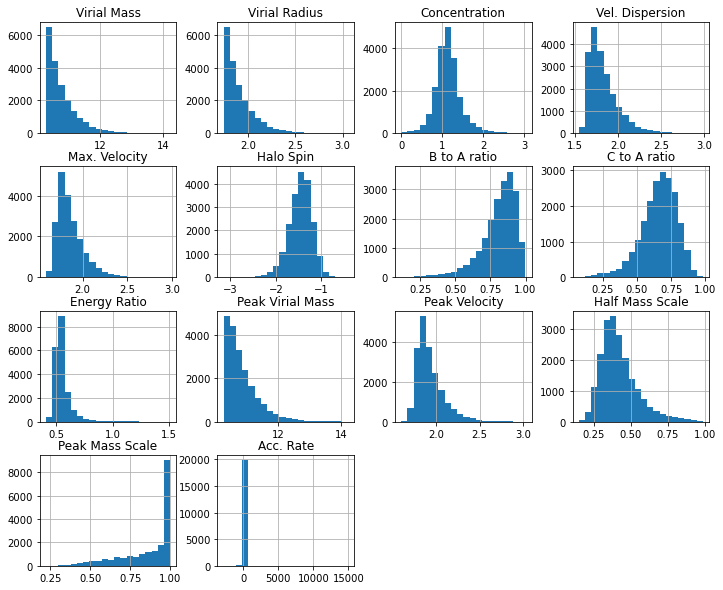

In [6]:
hist = halos.hist(bins=20, figsize=(12,10))

This plot shows a histogram for each halo property. Some features, like the virial mass, the peak virial mass, and the virial radius start very high and then decline (they don't have a maximum). Some other features, like the half mass scale factor, the concentration, and the spin have a clear peak.

### Correlations in the data
We want to predict the halo `'concentration'` from the other features. It is helpful to first get an idea how to do this, by visualizing the data, and then looking for correlations of each feature with the concentration. 
Lets create the Scatter Matrix for all the features in the dataframe,

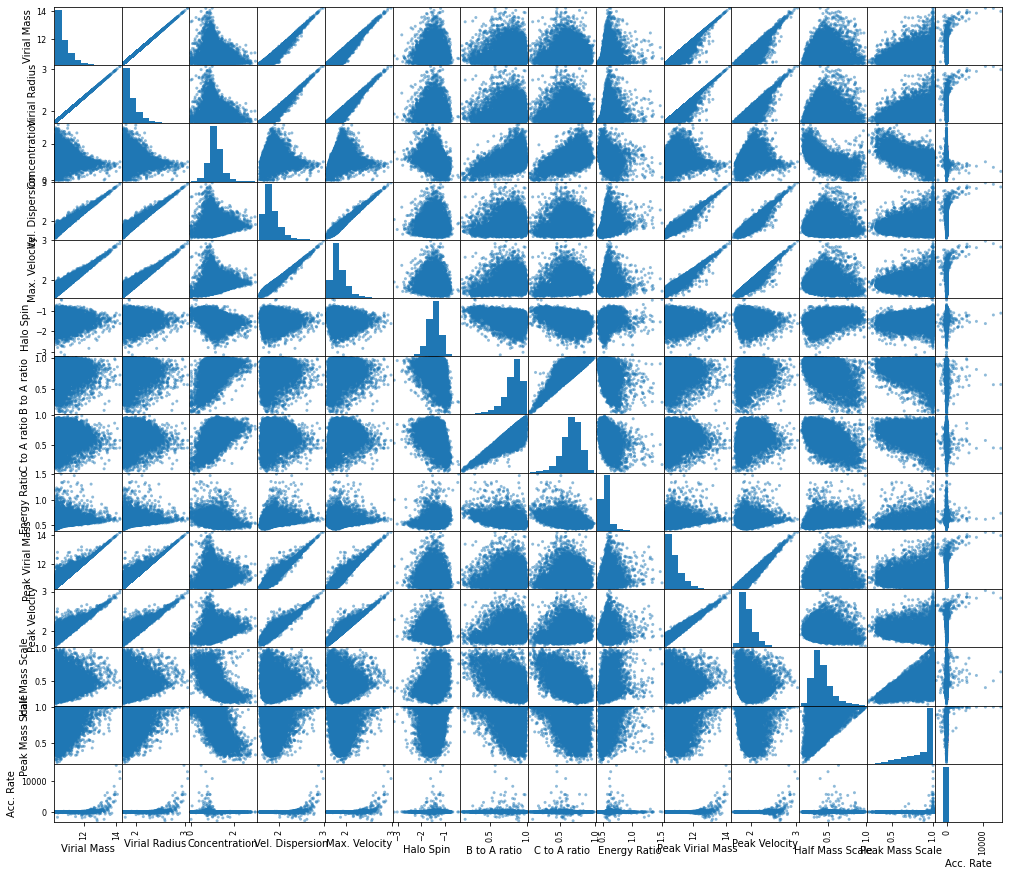

In [7]:
attributes=['Virial Mass', 
            'Virial Radius',
            'Concentration',
            'Vel. Dispersion',
            'Max. Velocity',
            'Halo Spin',
            'B to A ratio',
            'C to A ratio',
            'Energy Ratio',
            'Peak Virial Mass',
            'Peak Velocity',
            'Half Mass Scale',
            'Peak Mass Scale',
            'Acc. Rate'
           ]
scatMatrix=pd.plotting.scatter_matrix(halos[attributes], figsize=(17,15))

It seems that the `'concentration'`has some correlation with features such as `'Peak Virial Mass'`, `'Peak  Mass Scale'`, or `'Half Mass Scale'`. To obtain a better idea of the correlation, we use the `dataframe.corr()` method to obtain the correlation matrix,

In [8]:
#The .corr() function gives you the correlation matrix
halos.corr() 

,Virial Mass,Virial Radius,Concentration,Vel. Dispersion,Max. Velocity,Halo Spin,B to A ratio,C to A ratio,Energy Ratio,Peak Virial Mass,Peak Velocity,Half Mass Scale,Peak Mass Scale,Acc. Rate
Virial Mass,1.000000,1.000000,-0.196377,0.967605,0.949982,-0.029213,-0.021556,-0.029463,0.272805,0.949818,0.889722,0.189321,0.146670,0.235512
Virial Radius,1.000000,1.000000,-0.196377,0.967605,0.949982,-0.029212,-0.021555,-0.029463,0.272804,0.949817,0.889722,0.189321,0.146670,0.235513
Concentration,-0.196377,-0.196377,1.000000,0.000854,0.090973,-0.271236,0.396153,0.473164,-0.275653,-0.022214,0.162014,-0.617505,-0.547787,-0.074421
Vel. Dispersion,0.967605,0.967605,0.000854,1.000000,0.983143,-0.070276,0.013751,0.029394,0.345479,0.969816,0.944013,0.094555,0.012060,0.216618
Max. Velocity,0.949982,0.949982,0.090973,0.983143,1.000000,-0.112519,0.095872,0.115643,0.194249,0.956882,0.961052,-0.003824,-0.026541,0.217292
Halo Spin,-0.029213,-0.029212,-0.271236,-0.070276,-0.112519,1.000000,-0.262018,-0.284453,0.167200,-0.068650,-0.142464,0.308465,0.091812,0.022385
B to A ratio,-0.021556,-0.021555,0.396153,0.013751,0.095872,-0.262018,1.000000,0.816146,-0.422406,-0.004415,0.080924,-0.491409,-0.133920,-0.042667
C to A ratio,-0.029463,-0.029463,0.473164,0.029394,0.115643,-0.284453,0.816146,1.000000,-0.411123,0.014408,0.117836,-0.533568,-0.215692,-0.049380
Energy Ratio,0.272805,0.272804,-0.275653,0.345479,0.194249,0.167200,-0.422406,-0.411123,1.000000,0.295550,0.192510,0.415034,0.096284,0.063733
Peak Virial Mass,0.949818,0.949817,-0.022214,0.969816,0.956882,-0.068650,-0.004415,0.014408,0.295550,1.000000,0.960178,0.132965,-0.057965,0.206111


It is also possible to obtain the correlation coefficients of a particular feature with the rest of them by using a subscript with the name of the feature,

In [9]:
halos.corr()['Concentration']

Virial Mass        -0.196377
Virial Radius      -0.196377
Concentration       1.000000
Vel. Dispersion     0.000854
Max. Velocity       0.090973
Halo Spin          -0.271236
B to A ratio        0.396153
C to A ratio        0.473164
Energy Ratio       -0.275653
Peak Virial Mass   -0.022214
Peak Velocity       0.162014
Half Mass Scale    -0.617505
Peak Mass Scale    -0.547787
Acc. Rate          -0.074421
Name: Concentration, dtype: float64

In [10]:
#If you add .sort_values() the results will get sorted
halos.corr()['Concentration'].sort_values()

Half Mass Scale    -0.617505
Peak Mass Scale    -0.547787
Energy Ratio       -0.275653
Halo Spin          -0.271236
Virial Radius      -0.196377
Virial Mass        -0.196377
Acc. Rate          -0.074421
Peak Virial Mass   -0.022214
Vel. Dispersion     0.000854
Max. Velocity       0.090973
Peak Velocity       0.162014
B to A ratio        0.396153
C to A ratio        0.473164
Concentration       1.000000
Name: Concentration, dtype: float64

**It looks that `'concentration` has the highest (anti-)correlation with `'Half Mass Scale'`, although the 'correlation' with `'Peak Mass Scale'` is also significant.**


 We create a scatter plot of the 'concentration' vs. the high correlation features,

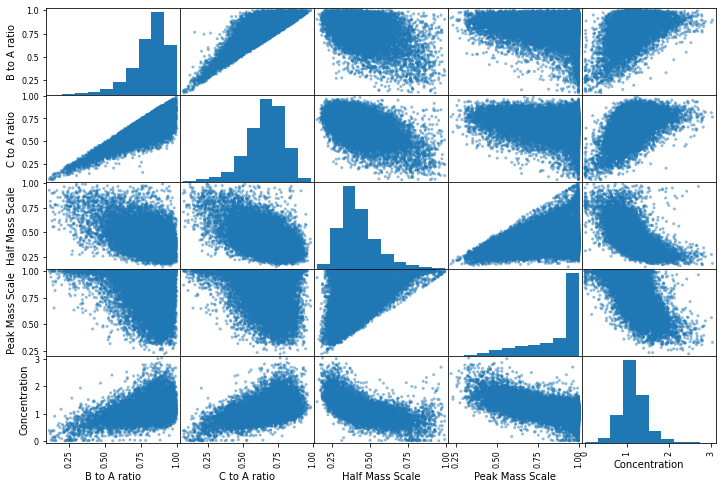

In [11]:
#Select most highly correlated features and show scatter plots
attributes=['B to A ratio','C to A ratio','Half Mass Scale','Peak Mass Scale','Concentration']
sm = pd.plotting.scatter_matrix(halos[attributes], figsize=(12,8))

It seems that the two highest correlated features are

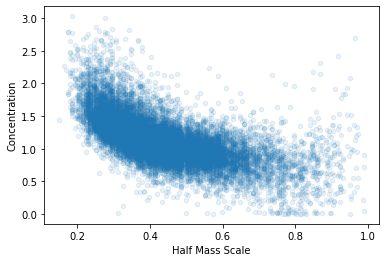

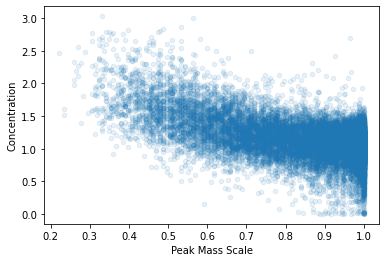

In [12]:
#Show scatter plot for highest correlation
highCorr1 = halos.plot(kind='scatter', x='Half Mass Scale', y='Concentration', alpha=0.1)
highCorr2 = halos.plot(kind='scatter', x='Peak Mass Scale', y='Concentration', alpha=0.1)

---

## Preparing the data for machine learning

We cannot directly feed a Pandas data frame to scikit-learn. In order to train the 1D linear regressor, we define

In [13]:
Xdf = halos[['Half Mass Scale']]
ydf = halos[['Concentration']]

### Splitting the data into training and test sets

In the next step, we will use the `Scikit-Learn` library to predict the halo `'concentration'` from the other halo properties using a simple linear regression. 

As is common in machine learning, we will want to test how well our solutions generalise to other data sets.
It doesn't help us, if the algorithm learned how to model a feature for our training set very well, if it completely fails when used with a different data set.  

Therefore, we need to split our data set into a training and a test set. We split train and test sets randomly using 20% of the total data set as test set.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(Xdf, ydf, random_state=413, test_size=0.2)
X_train.shape , y_train.shape

((16000, 1), (16000, 1))

### Training a linear regression

With the prepared data, we can simply select a regressor and train it.


In [15]:
#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

### Final evaluation on the test set

Once we have the linear model, we will test it by computing the prediction for the targets in the test set and meassure the final RMSE with respect to the knwon concentrations. We use the [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) metric.

In [16]:
#Compute Predictions and determine RMSE (=root mean squared error)
predictions = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.2519589264196016

Remember that the smaller the RMSE, the better the model. For this little work, this is not too bad. 

The method `.score()`,  returns the coefficient of determination $R^2$ for the model. 

In [17]:
lin_reg.score(X_test,y_test)

0.3851238038909284

Finally, we plot the predicted concentrations vs. the labels (i.e. the real concentrations).

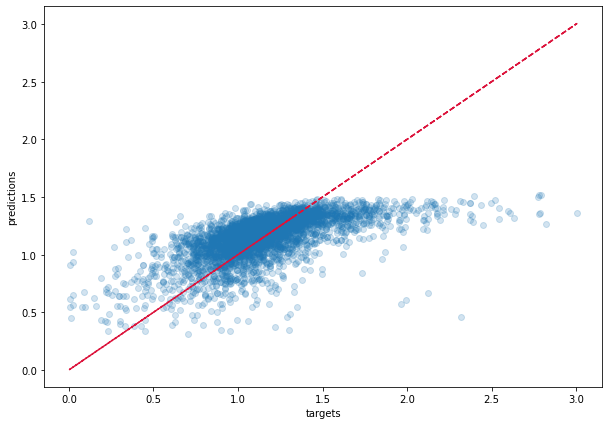

In [18]:
plt.figure(figsize=(10,7))
plt.scatter(y_test, predictions, alpha=0.2)
plt.plot(y_test, y_test, '--', color='crimson')
plt.ylabel(r'predictions')
plt.xlabel(r'targets')
plt.show()

### A Multidimensional Linear Regression

Since we have other features that are correlated with the `'concentration'`, we use them to improve the linear regression. First we will use two features, `'Half Mass Scale'` and `'Peak Mass Scale'`, to train the algorithm.

In [19]:
Xdf2 = halos[['Half Mass Scale','Peak Mass Scale']]
ydf2 = halos[['Concentration']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(Xdf2, ydf2, random_state=413, test_size=0.2)
X_train2.shape , y_train2.shape

((16000, 2), (16000, 1))

In [20]:
#Linear Regression
lin_reg2 = LinearRegression()
lin_reg2.fit(X_train2, y_train2)

LinearRegression()

In [21]:
#Compute Predictions and determine RMSE (=root mean squared error)
predictions2 = lin_reg2.predict(X_test2)
lin_mse2 = mean_squared_error(y_test2, predictions2)
lin_rmse2 = np.sqrt(lin_mse2)
lin_rmse2

0.2148540473166986

In [22]:
lin_reg2.score(X_test2,y_test2)

0.5528890971838798

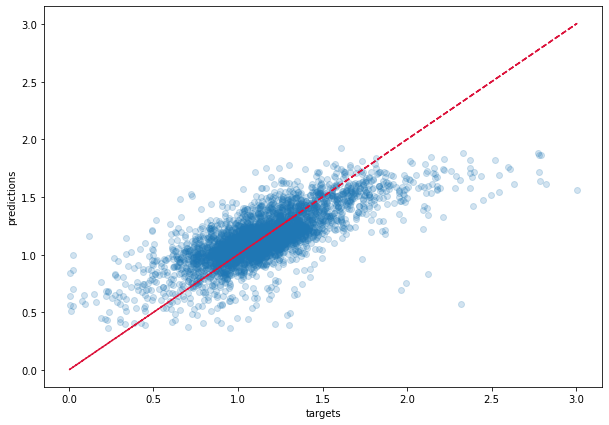

In [23]:
plt.figure(figsize=(10,7))
plt.scatter(y_test2, predictions2, alpha=0.2)
plt.plot(y_test2, y_test2, '--', color='crimson')
plt.ylabel(r'predictions')
plt.xlabel(r'targets')
plt.show()

In fact the model is improved!

Now we will use four features to predict the `'concentration'`.

In [24]:
Xdf3 = halos[['Half Mass Scale','Peak Mass Scale', 'B to A ratio','C to A ratio']]
ydf3 = halos[['Concentration']]

X_train3, X_test3, y_train3, y_test3 = train_test_split(Xdf3, ydf3, random_state=413, test_size=0.2)
X_train3.shape , y_train3.shape

((16000, 4), (16000, 1))

In [25]:
#Linear Regression
lin_reg3 = LinearRegression()
lin_reg3.fit(X_train3, y_train3)

#Compute Predictions and determine RMSE (=root mean squared error)
predictions3 = lin_reg3.predict(X_test3)
lin_mse3 = mean_squared_error(y_test3, predictions3)
lin_rmse3 = np.sqrt(lin_mse3)
lin_rmse3

0.21054410346335528

In [26]:
lin_reg3.score(X_test3,y_test3)

0.5706471520000853

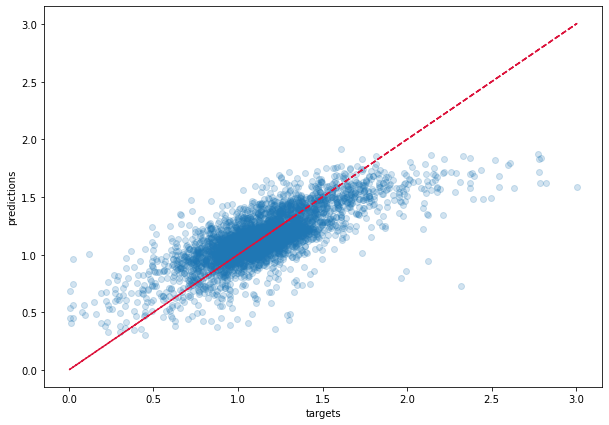

In [27]:
plt.figure(figsize=(10,7))
plt.scatter(y_test3, predictions3, alpha=0.2)
plt.plot(y_test3, y_test3, '--', color='crimson')
plt.ylabel(r'predictions')
plt.xlabel(r'targets')
plt.show()